In [ ]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from pyha import *
from pyha.cores import *
from pyha.cores.util import *
import scipy
from scipy import signal
import warnings
warnings.filterwarnings('ignore') # yolo!
import numpy as np
import inspect

# GitHub cannot display the Table of Contents!

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Info


In [2]:
print(inspect.getdoc(R2SDF))
print('\n\nMain interface\n' + inspect.getdoc(R2SDF.main))

FFT core
--------

Uses the R2SDR structure with 18bit data-width and rounded logic - no DC-bias introduced.
Scaling is opposite to Numpy i.e. "fft *= FFT_SIZE" and "ifft /= FFT_SIZE", this way values always stay
in -1 ... 1 range.

Args:
    fft_size: Transform size, must be power of 2.
    twiddle_bits: Stored as constants in LUTS. For big transforms you should try ~9 bits.
    inverse (bool): True to perform inverse transform.
    input_ordering (str): 'natural' or 'bitreversed'.
        Output order is inverse of this - Natural(in) -> Bitreversed(out) or Bitreversed(in) -> Natural(out).


Main interface
Args:
    input (DataValid): -1.0 ... 1.0 range, up to 18 bits

Returns:
    DataValid: 18 bits(-1.0 ... 1.0 range) if transform size is up to 1024 points.
        Transforms over 1024 points start emphasizing smaller numbers e.g. 2048 would return a result with 18 bits
        but in -0.5 ... 0.5 range (one extra bit for smaller numbers) etc...


# Examples

## Forward FFT

INFO:sim:Tracing is enabled, running "MODEL" and "HARDWARE" simulations
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "HARDWARE" simulation...


100%|██████████| 1024/1024 [00:00<00:00, 2321.05it/s]

INFO:sim:Flushing the pipeline to collect 1024 valid samples (currently have 744)


INFO:sim:Flush took 280 cycles.
INFO:sim:OK!
INFO:sim:Simulations completed!


<IPython.core.display.Javascript object>


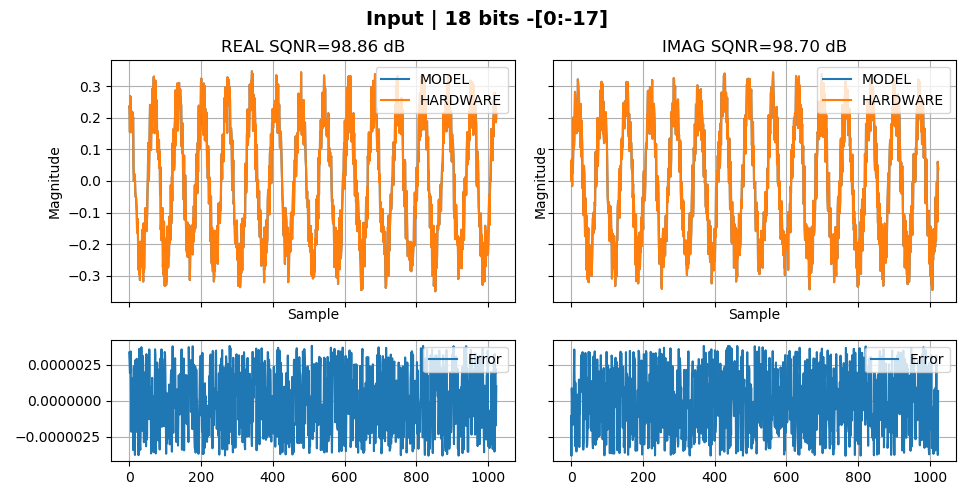

<IPython.core.display.Javascript object>


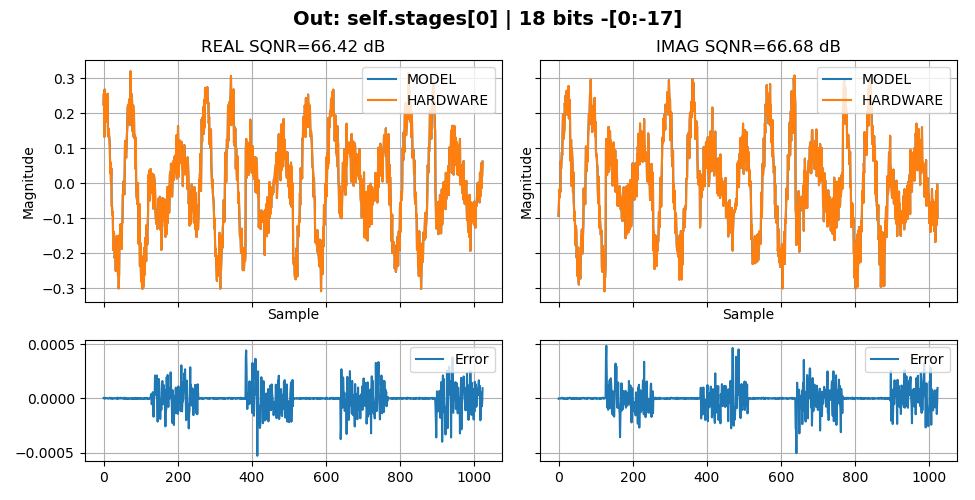

<IPython.core.display.Javascript object>


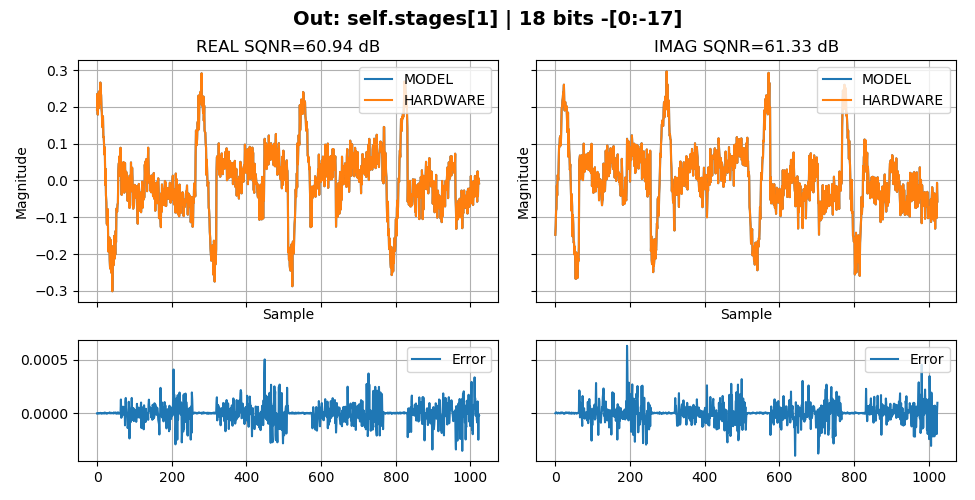

<IPython.core.display.Javascript object>


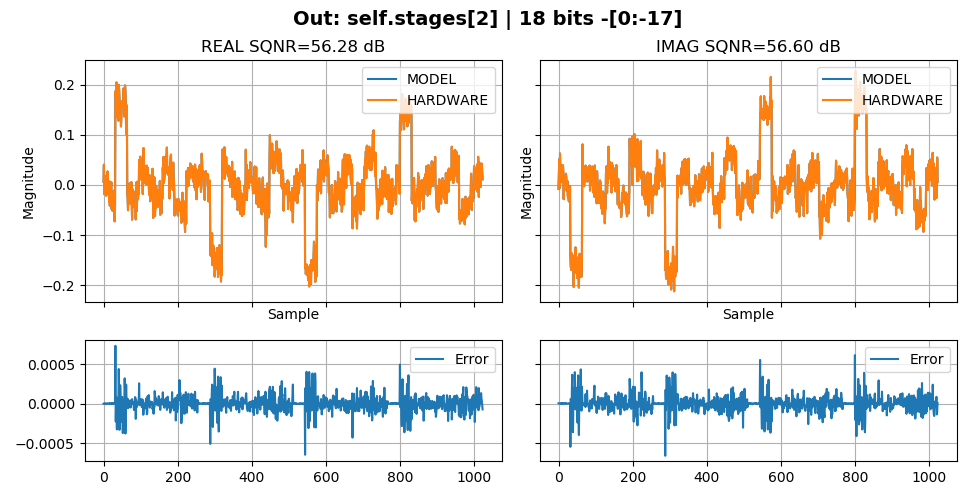

<IPython.core.display.Javascript object>


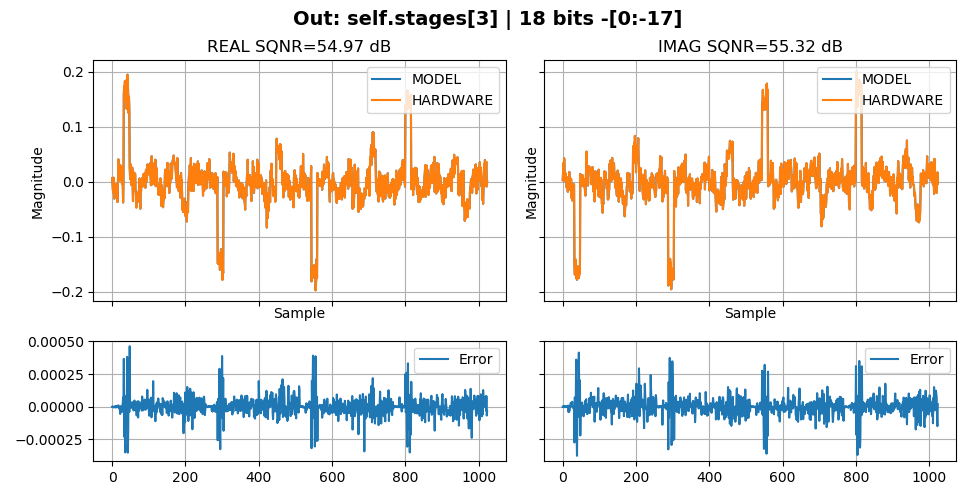

<IPython.core.display.Javascript object>


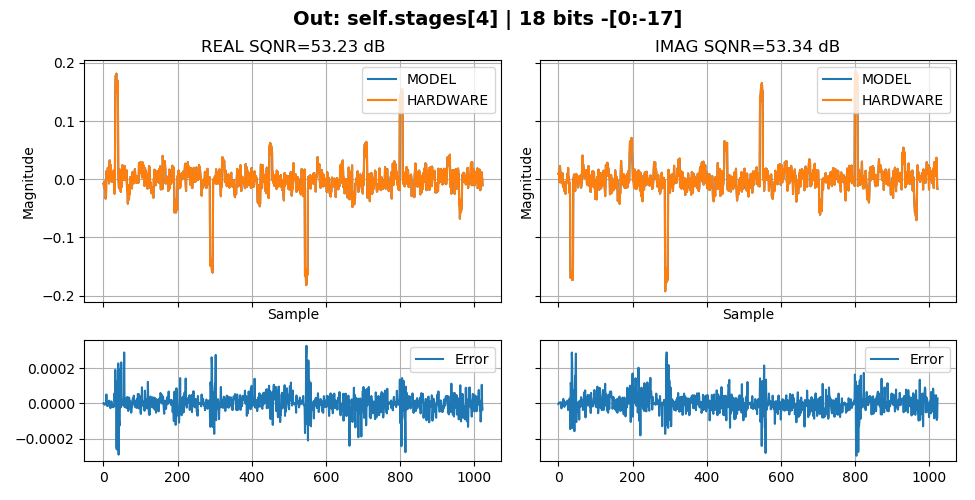

<IPython.core.display.Javascript object>


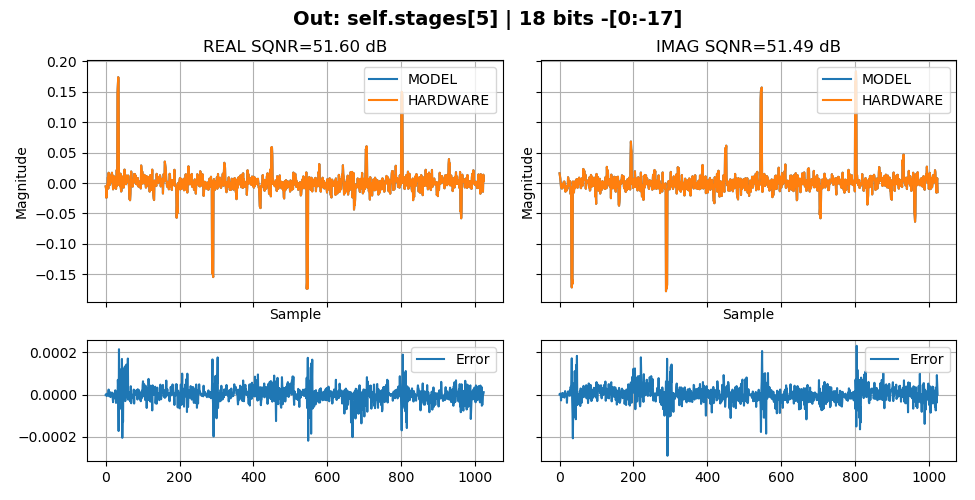

<IPython.core.display.Javascript object>


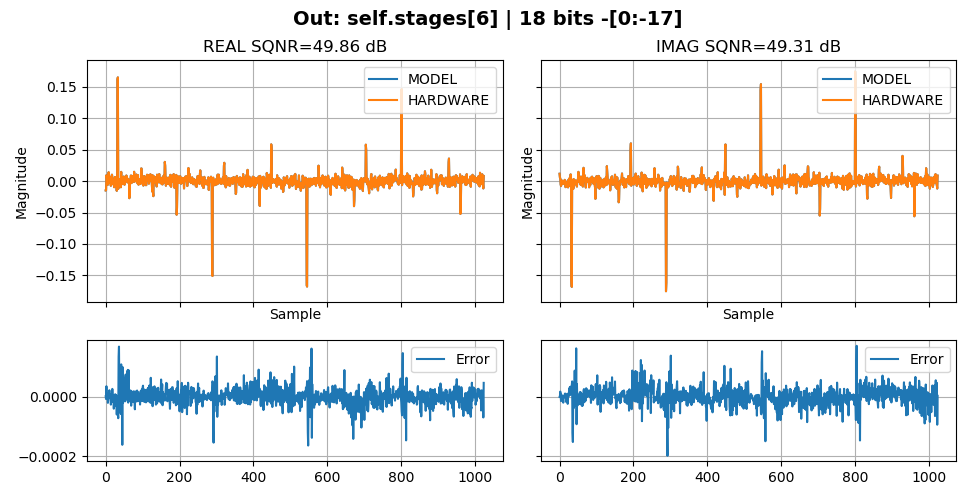

<IPython.core.display.Javascript object>


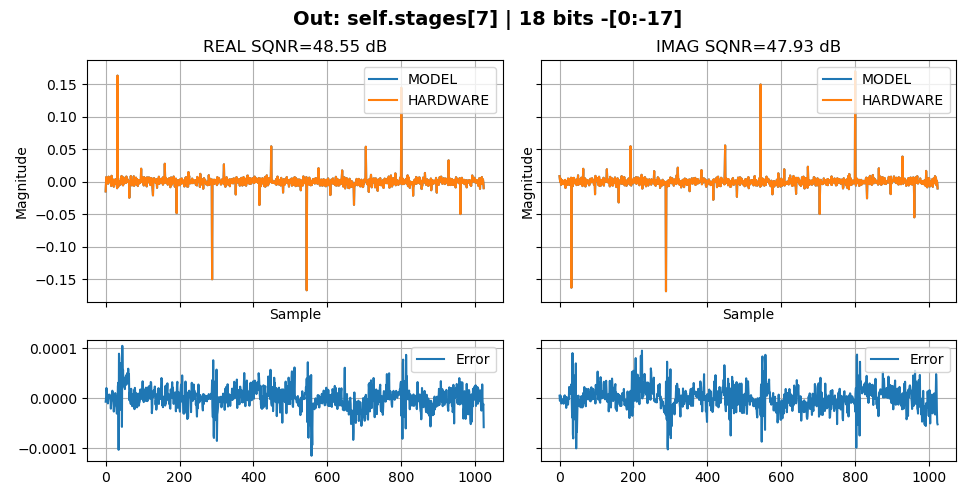

In [3]:
fft_size = 256
samples = 1024
freq = 15
sine = np.exp(2j*np.pi*np.linspace(0, 1, samples)*freq) * 0.25
noise = np.random.uniform(-1, 1, samples) + np.random.uniform(-1, 1, samples) * 1j
forward_input_signal = sine + noise * 0.1

dut = R2SDF(fft_size, twiddle_bits=9)
forward_sims = simulate(dut, forward_input_signal, trace=True, pipeline_flush='auto') # run simulations and gather trace
plot_trace()

## Inverse FFT

INFO:sim:Tracing is enabled, running "MODEL" and "HARDWARE" simulations
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "HARDWARE" simulation...


100%|██████████| 1024/1024 [00:00<00:00, 2064.10it/s]

INFO:sim:Flushing the pipeline to collect 1024 valid samples (currently have 744)


ERROR:complex:WRAP -1.32129-1.26953j -> 0.678711+0.730469j	[]
ERROR:complex:WRAP -1.32129-1.26953j -> 0.678711+0.730469j	[]
ERROR:complex:WRAP 1.35742+1.46094j -> -0.642578-0.539062j	[]
INFO:sim:Flush took 280 cycles.
INFO:sim:OK!
INFO:sim:Simulations completed!


<IPython.core.display.Javascript object>


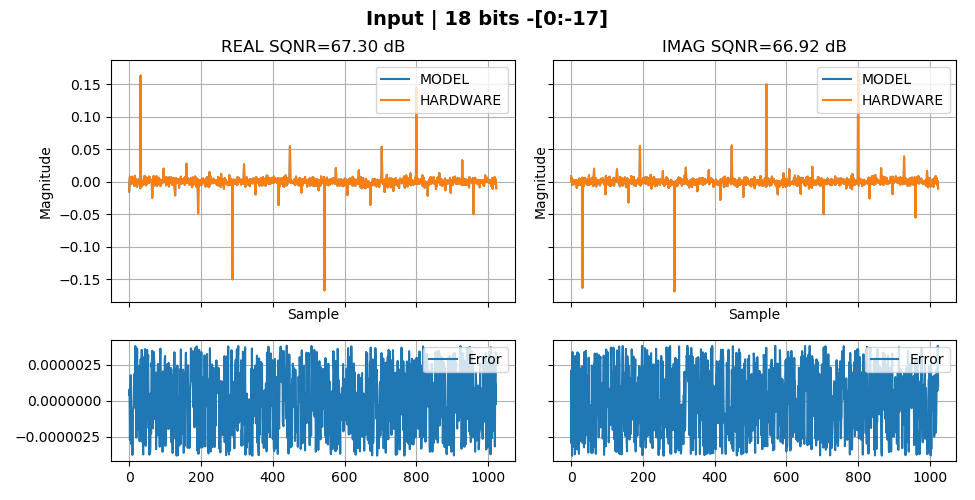

<IPython.core.display.Javascript object>


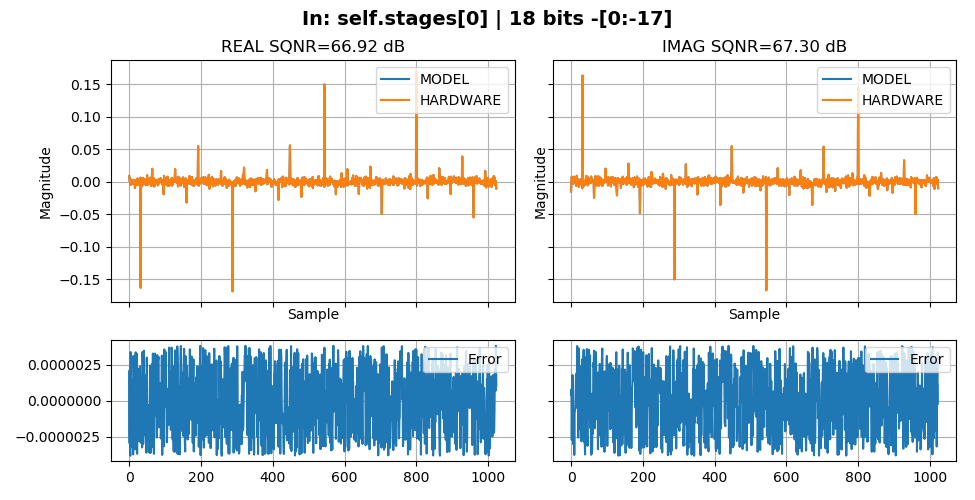

<IPython.core.display.Javascript object>


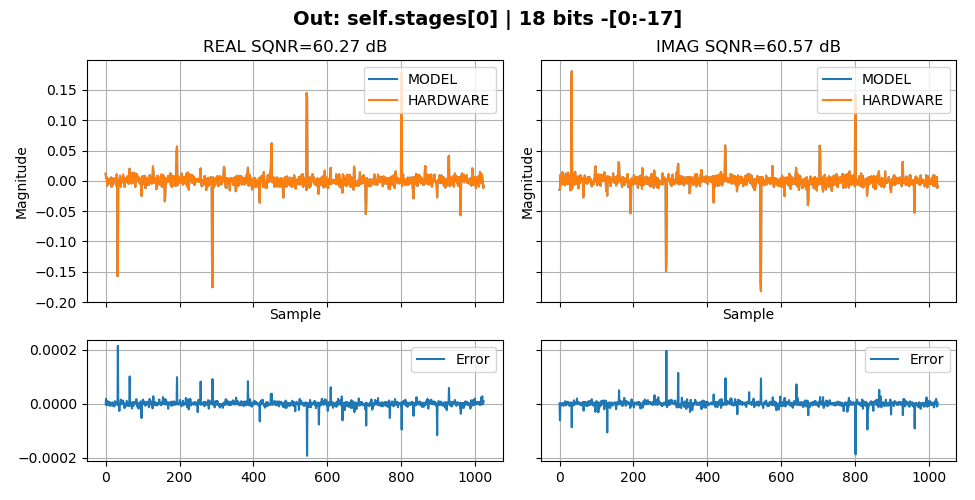

<IPython.core.display.Javascript object>


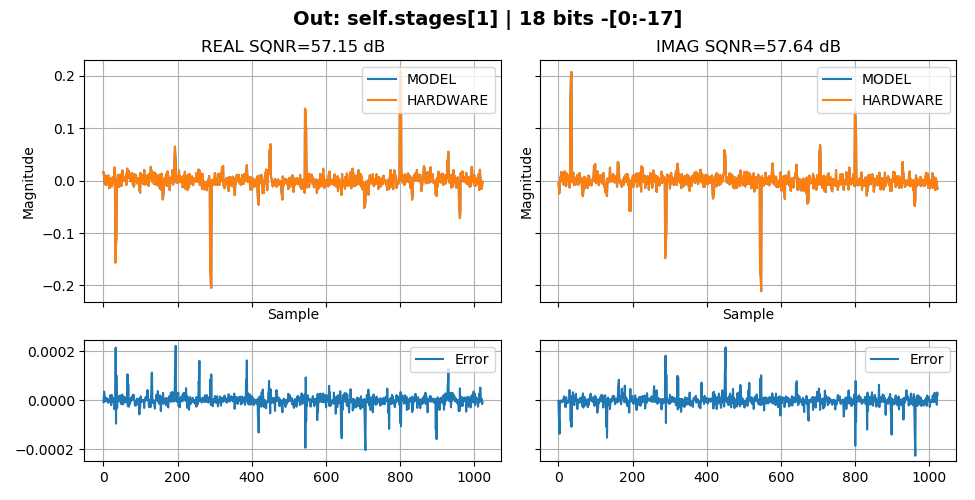

<IPython.core.display.Javascript object>


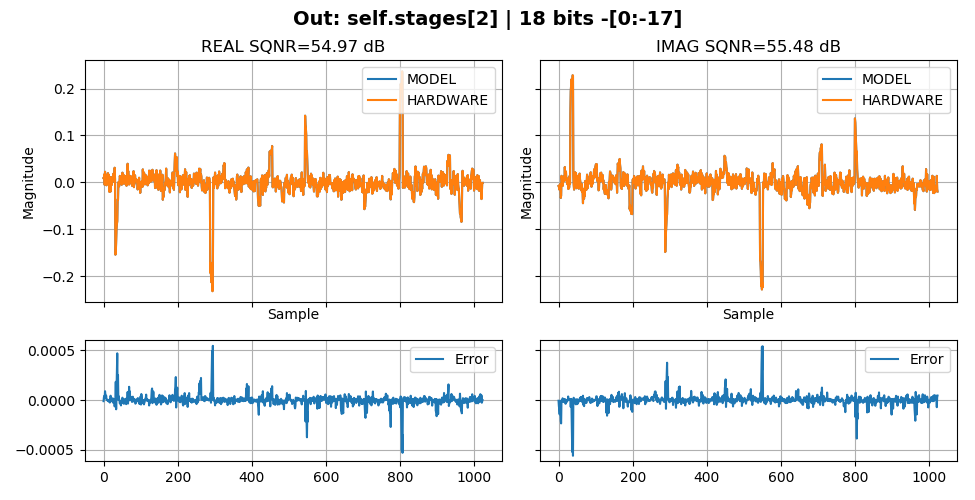

<IPython.core.display.Javascript object>


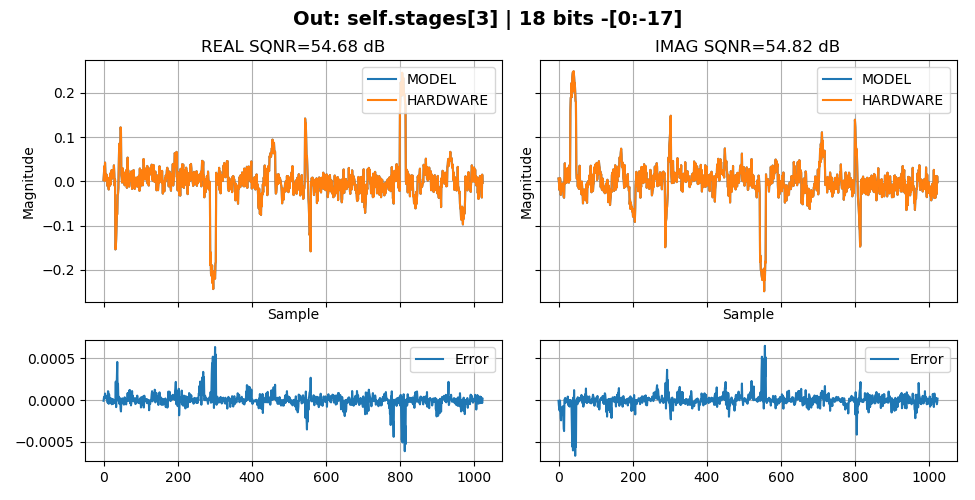

<IPython.core.display.Javascript object>


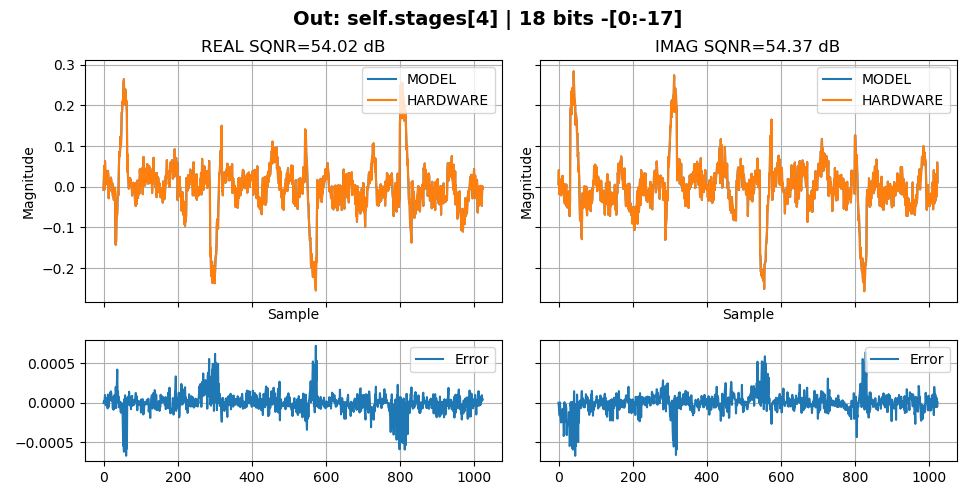

<IPython.core.display.Javascript object>


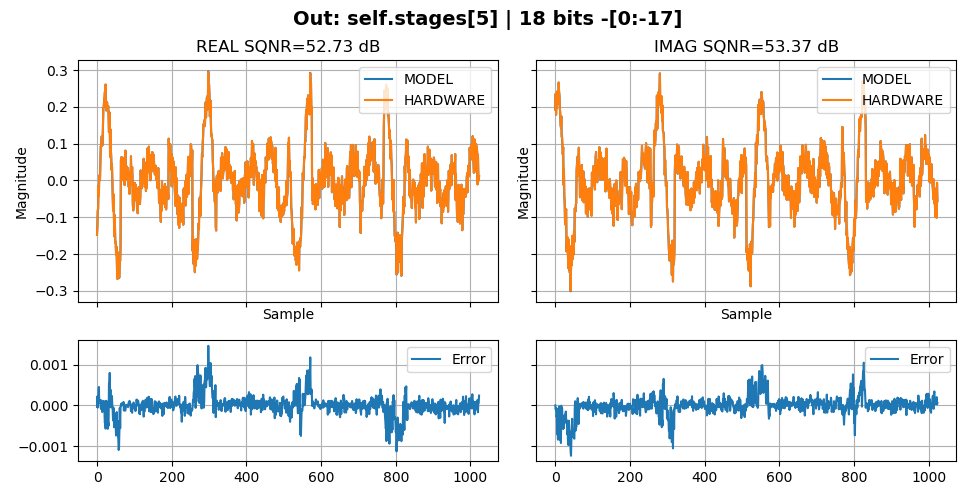

<IPython.core.display.Javascript object>


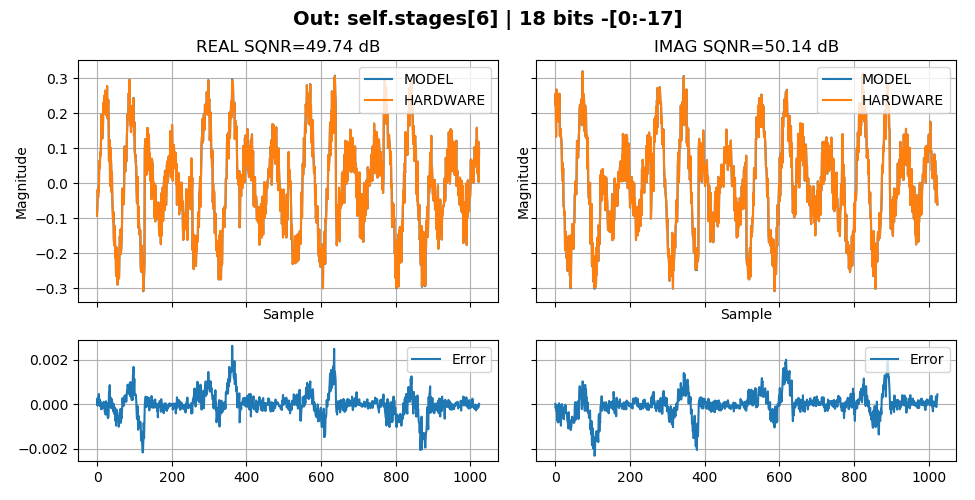

<IPython.core.display.Javascript object>


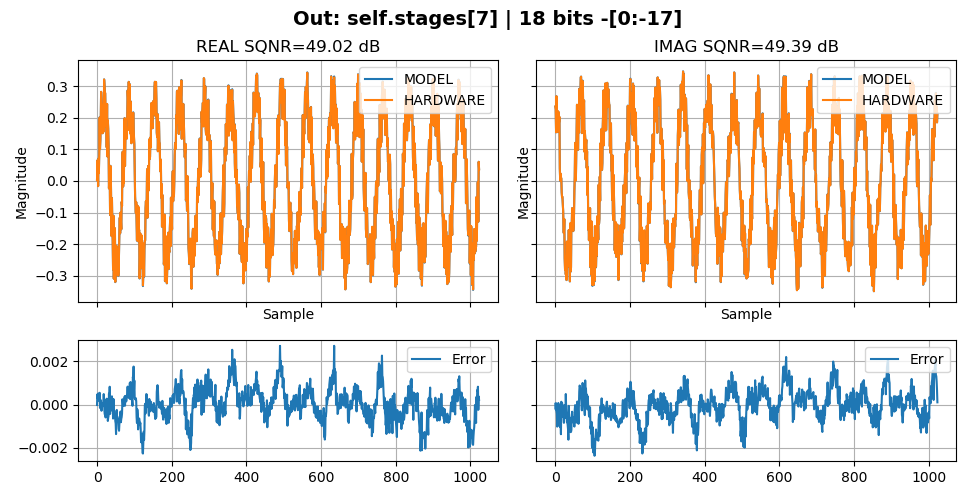

<IPython.core.display.Javascript object>


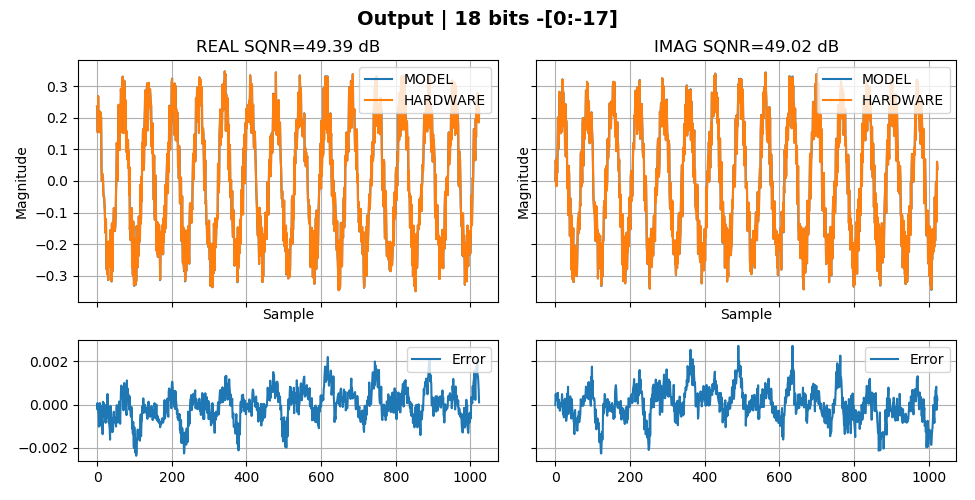

In [4]:
# use input from the forward FFT, that is in 'bitreversed' format.
inverse_input=forward_sims['MODEL']
dut = R2SDF(fft_size, twiddle_bits=9, inverse=True, input_ordering='bitreversed')
sims = simulate(dut, inverse_input, trace=True, pipeline_flush='auto')
plot_trace()

# Conversion/Synthesis

## Forward FFT

In [6]:
# Pyha supports running 'RTL' (using GHDL) and 'NETLIST' (netlist after quartus_map) level simulations.
dut = R2SDF(fft_size, twiddle_bits=9)
sims = simulate(dut, forward_input_signal[:fft_size], pipeline_flush='auto', 
                simulations=['MODEL', 'HARDWARE', 'RTL', 'NETLIST'], 
                conversion_path='/tmp/pyha_output')
assert hardware_sims_equal(sims)

quartus = get_simulator_quartus()
print(quartus.get_resource_usage('fit'))
print(quartus.get_fmax())

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Simulaton needs to support conversion to VHDL -> major slowdown
INFO:sim:Running "HARDWARE" simulation...


100%|██████████| 256/256 [00:00<00:00, 993.91it/s] 

INFO:sim:Flushing the pipeline to collect 256 valid samples (currently have 0)


INFO:sim:Flush took 280 cycles.
INFO:sim:OK!
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataValid to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to 

Family : Cyclone IV E
Device : EP4CE40F23C8
Timing Models : Final
Total logic elements : 2,264 / 39,600 ( 6 % )
    Total combinational functions : 2,038 / 39,600 ( 5 % )
    Dedicated logic registers : 1,332 / 39,600 ( 3 % )
Total registers : 1332
Total pins : 76 / 329 ( 23 % )
Total virtual pins : 0
Total memory bits : 8,640 / 1,161,216 ( < 1 % )
Embedded Multiplier 9-bit elements : 56 / 232 ( 24 % )
Total PLLs : 0 / 4 ( 0 % )

+-------------------------------------------------+
; Fmax Summary                                    ;
+-----------+-----------------+------------+------+
; Fmax      ; Restricted Fmax ; Clock Name ; Note ;
+-----------+-----------------+------------+------+
; 95.15 MHz ; 95.15 MHz       ; clk        ;      ;
+-----------+-----------------+------------+------+
This panel reports FMAX for every clock in the design, regardless of the user-specified clock periods.  FMAX is only computed for paths where the source and destination registers or ports are driven by 

## Inverse FFT

In [5]:
dut = R2SDF(fft_size, twiddle_bits=9, inverse=True, input_ordering='bitreversed')
sims = simulate(dut, inverse_input[:fft_size], pipeline_flush='auto', 
                simulations=['MODEL', 'HARDWARE', 'RTL', 'NETLIST'], 
                conversion_path='/tmp/pyha_output')
assert hardware_sims_equal(sims)

quartus = get_simulator_quartus()
print(quartus.get_resource_usage('fit'))
print(quartus.get_fmax())

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Simulaton needs to support conversion to VHDL -> major slowdown
INFO:sim:Running "HARDWARE" simulation...


100%|██████████| 256/256 [00:00<00:00, 371.57it/s]

INFO:sim:Flushing the pipeline to collect 256 valid samples (currently have 0)


ERROR:complex:WRAP 0.313477-1.03613j -> 0.313477+0.963867j	[R2SDF.main()-StageR2SDF.main()-StageR2SDF.butterfly()]
ERROR:complex:WRAP 0.313477-1.03613j -> 0.313477+0.963867j	[R2SDF.main()-StageR2SDF.main()-StageR2SDF.butterfly()]
ERROR:complex:WRAP 0.626953+1.92773j -> 0.626953-0.0722656j	[R2SDF.main()-StageR2SDF.main()-StageR2SDF.butterfly()]
INFO:sim:Flush took 280 cycles.
INFO:sim:OK!
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataValid to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:con

Family : Cyclone IV E
Device : EP4CE40F23C8
Timing Models : Final
Total logic elements : 2,231 / 39,600 ( 6 % )
    Total combinational functions : 2,083 / 39,600 ( 5 % )
    Dedicated logic registers : 1,293 / 39,600 ( 3 % )
Total registers : 1293
Total pins : 76 / 329 ( 23 % )
Total virtual pins : 0
Total memory bits : 8,748 / 1,161,216 ( < 1 % )
Embedded Multiplier 9-bit elements : 56 / 232 ( 24 % )
Total PLLs : 0 / 4 ( 0 % )

+-------------------------------------------------+
; Fmax Summary                                    ;
+-----------+-----------------+------------+------+
; Fmax      ; Restricted Fmax ; Clock Name ; Note ;
+-----------+-----------------+------------+------+
; 98.87 MHz ; 98.87 MHz       ; clk        ;      ;
+-----------+-----------------+------------+------+
This panel reports FMAX for every clock in the design, regardless of the user-specified clock periods.  FMAX is only computed for paths where the source and destination registers or ports are driven by 